In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt
import os
os.makedirs('result', exist_ok=True)
plt.rcParams['font.sans-serif'] = 'simhei'  # 设置字体
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 读入鸢尾花数据
iris_df = pd.read_csv('iris.csv' ,encoding='gbk', header=None)
# 重新设置数据列名
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'category']
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,category
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
x_real = iris_df.drop(columns=['category']).to_numpy()
y_real = iris_df['category'].to_numpy()
x_real.shape, y_real.shape

((150, 4), (150,))

In [4]:
def pca_(dataset, k=2, svd=False):
    """
    使用主成分分析算法，把n维数据集降为k维数据
    :param dataset: 数据集n*m,n为特征数,m为样本数,np.array
    :param svd: 是否使用奇异值分解求特征值
    :return: 降维后的数据集k*m，和信息量占比t
    """
    dataset = dataset.T
    dataset = pp.scale(dataset, axis=1)  # 去均值化
    cov_mat = np.cov(dataset)  # 计算协方差矩阵
    if svd:  # 使用SVD（奇异值分解）求解
        u, s, vt = np.linalg.svd(cov_mat)  # s存储奇异值，u存储对应的特征向量
        eig_vals = s[: k]  # 选取前K个奇异值，对应特征值
        red_eig_vects = u[:, : k]  # 选取对应的特征向量， n*k
        t = np.sum(eig_vals) / np.sum(s)  # 计算信息保留度

    else:  # 使用求解特征值和特征矩阵的方式
        eig_vals, eig_vects = np.linalg.eig(cov_mat)  # 计算协方差矩阵的特征值和特征向量
        eig_vals_ind = np.argsort(eig_vals)[:: -1][: k]  # 获取前k个最大特征值的索引
        red_eig_vects = eig_vects[:, eig_vals_ind]  # 根据索引获取对应的特征向量
        # 在PCA，特征值等于对应特征向量*原数据后的方差，这里用方差代表信息量，该值衡量降维后保留的原数据多少的信息量
        t = np.sum(eig_vals[eig_vals_ind]) / np.sum(eig_vals)
    low_dim_data = np.dot(red_eig_vects.T, dataset)  # 特征向量*去均值化的原数据=降维后的数据
    return low_dim_data.T, t

In [5]:
pca = PCA(n_components=2)
pca.fit(x_real)

PCA(n_components=2)

In [6]:
x_pca_, _ = pca_(x_real)
x_pca_svd, _ = pca_(x_real, svd = True)
x_pca = pca.transform(x_real)

# x_pca_[:10], x_pca_svd[:10], x_pca[:10]
x_pca_.shape, x_pca_svd.shape, x_pca.shape

((150, 2), (150, 2), (150, 2))

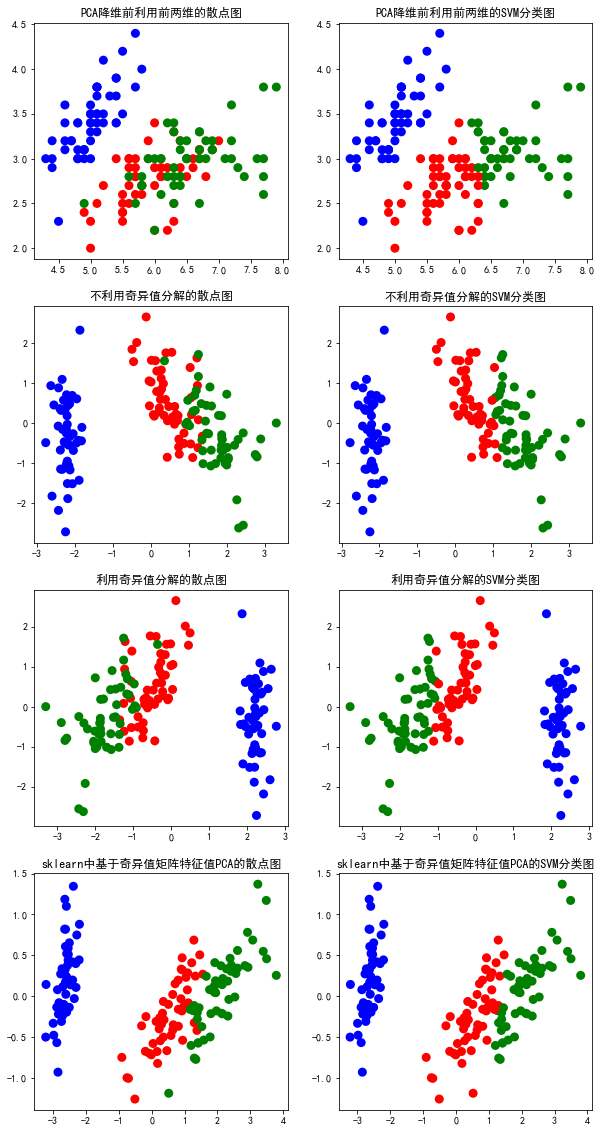

0.82 0.92 0.92 0.96


In [7]:
category_color = {'Iris-setosa': 'b', 'Iris-versicolor': 'r', 'Iris-virginica':'g'}
category_label = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
label_color = ['b', 'r', 'g']

y_real_c = [category_color[x] for x in y_real]
y_real_label = np.array([category_label[x] for x in y_real]).reshape(-1,)

plt.figure(figsize=(10, 20))
plt.subplot(421)
plt.title("PCA降维前利用前两维的散点图")
plt.scatter(x_real[:, 0], x_real[:, 1], c=y_real_c, lw=3)

plt.subplot(422)
clf = svm.SVC()
clf.fit(x_real[:, 0:2], y_real_label)
y_pred = clf.predict(x_real[:, 0:2])
y_pred_c = [label_color[x] for x in y_pred]
plt.scatter(x_real[:, 0], x_real[:, 1], c=y_pred_c, lw=3)
plt.title("PCA降维前利用前两维的SVM分类图")
score_1 = clf.score(x_real[:, 0:2], y_real_label)

# 不利用奇异值分解的PCA
plt.subplot(423)
plt.title("不利用奇异值分解的散点图")
plt.scatter(x_pca_[:, 0], x_pca_[:, 1], c=y_real_c, lw=3)

plt.subplot(424)
clf = svm.SVC()
clf.fit(x_pca_[:, 0:2], y_real_label)
y_pred = clf.predict(x_pca_[:, 0:2])
y_pred_c = [label_color[x] for x in y_pred]
plt.scatter(x_pca_[:, 0], x_pca_[:, 1], c=y_pred_c, lw=3)
plt.title("不利用奇异值分解的SVM分类图")
score_2 = clf.score(x_pca_[:, 0:2], y_real_label)

# 利用奇异值分解的PCA
plt.subplot(425)
plt.title("利用奇异值分解的散点图")
plt.scatter(x_pca_svd[:, 0], x_pca_svd[:, 1], c=y_real_c, lw=3)

plt.subplot(426)
clf = svm.SVC()
clf.fit(x_pca_svd[:, 0:2], y_real_label)
y_pred = clf.predict(x_pca_svd[:, 0:2])
y_pred_c = [label_color[x] for x in y_pred]
plt.scatter(x_pca_svd[:, 0], x_pca_svd[:, 1], c=y_pred_c, lw=3)
plt.title("利用奇异值分解的SVM分类图")
score_3 = clf.score(x_pca_svd[:, 0:2], y_real_label)

# sklearn中基于奇异值矩阵特征值PCA
plt.subplot(427)
plt.title("sklearn中基于奇异值矩阵特征值PCA的散点图")
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_real_c, lw=3)

plt.subplot(428)
clf = svm.SVC()
clf.fit(x_pca[:, 0:2], y_real_label)
y_pred = clf.predict(x_pca[:, 0:2])
y_pred_c = [label_color[x] for x in y_pred]
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_pred_c, lw=3)
plt.title("sklearn中基于奇异值矩阵特征值PCA的SVM分类图")
score_4 = clf.score(x_pca[:, 0:2], y_real_label)

plt.savefig(os.path.join('result', 'result.jpg'))
plt.show()
print(score_1, score_2, score_3, score_4)